# In class

In [6]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
import seaborn as sns
from   IPython.display                 import display
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   statsmodels.tsa.seasonal        import seasonal_decompose, STL
from   datetime                        import  datetime,timedelta
from sklearn.model_selection import train_test_split
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

### Read retail turnover data 

In [7]:
df = pd.read_csv("RetailTurnover.csv")
df.head()

,Year,Quarter,Turnover
0,1982,Q3,13423.2
1,1982,Q4,13128.8
2,1983,Q1,15398.8
3,1983,Q2,12964.2
4,1983,Q3,13133.5


In [8]:
def year_qtr_to_date(year,quarter):
    qtr_month = {'Q1':3, 'Q2':6, 'Q3':9, 'Q4':12}
    month = qtr_month[quarter]
    last_day = pd.Timestamp(year, month, 1) + pd.offsets.MonthEnd(0)
    return last_day

df['date'] = df.apply(lambda x: year_qtr_to_date(x['Year'],x['Quarter']),axis = 1)
df.head()

,Year,Quarter,Turnover,date
0,1982,Q3,13423.2,1982-09-30
1,1982,Q4,13128.8,1982-12-31
2,1983,Q1,15398.8,1983-03-31
3,1983,Q2,12964.2,1983-06-30
4,1983,Q3,13133.5,1983-09-30


In [9]:
df.dtypes

Year                 int64
Quarter             object
Turnover           float64
date        datetime64[ns]
dtype: object

In [10]:
df.drop(columns=['Year','Quarter'],inplace=True)
df.set_index('date',inplace=True)
df.head()

,Turnover
date,
1982-09-30,13423.2
1982-12-31,13128.8
1983-03-31,15398.8
1983-06-30,12964.2
1983-09-30,13133.5


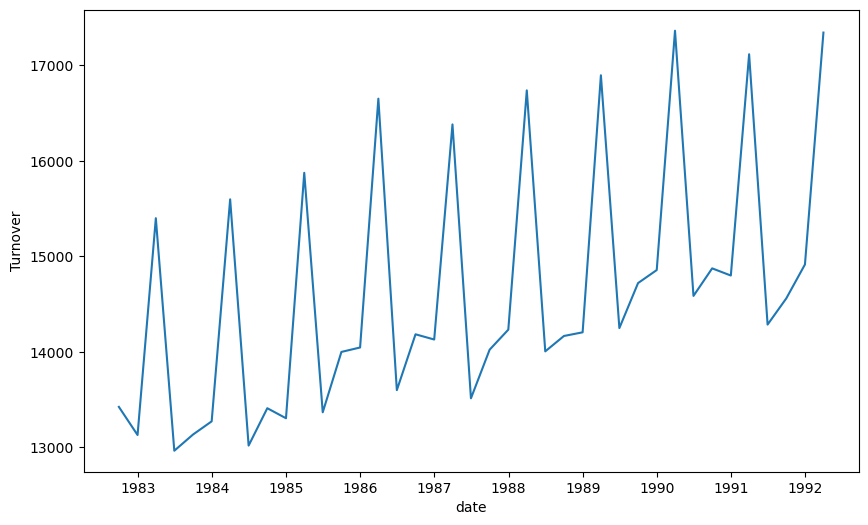

In [11]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df,x=df.index,y='Turnover')
plt.show()

# Decompose the series to identify trends and seasonality

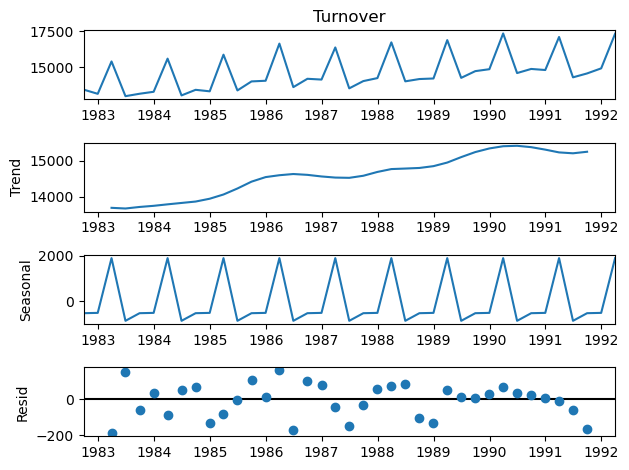

In [12]:
result_add = seasonal_decompose(df['Turnover'], model='additive', period=4)
result_add.plot()
plt.show()

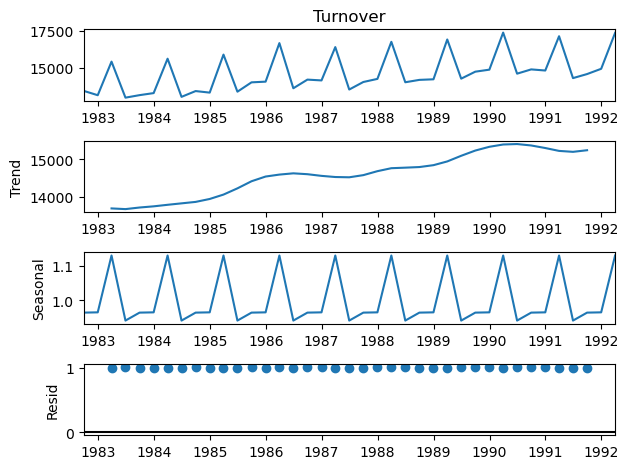

In [13]:
result_mul = seasonal_decompose(df['Turnover'], model='mul', period=4)
result_mul.plot()
plt.show()

## Split the time series data into training and testing sets

In [14]:
df.index

DatetimeIndex(['1982-09-30', '1982-12-31', '1983-03-31', '1983-06-30',
               '1983-09-30', '1983-12-31', '1984-03-31', '1984-06-30',
               '1984-09-30', '1984-12-31', '1985-03-31', '1985-06-30',
               '1985-09-30', '1985-12-31', '1986-03-31', '1986-06-30',
               '1986-09-30', '1986-12-31', '1987-03-31', '1987-06-30',
               '1987-09-30', '1987-12-31', '1988-03-31', '1988-06-30',
               '1988-09-30', '1988-12-31', '1989-03-31', '1989-06-30',
               '1989-09-30', '1989-12-31', '1990-03-31', '1990-06-30',
               '1990-09-30', '1990-12-31', '1991-03-31', '1991-06-30',
               '1991-09-30', '1991-12-31', '1992-03-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [15]:
#lets consider the last 9 records as test set
train, test = train_test_split(df,test_size=(9/df.shape[0]),random_state=10,shuffle=False)

In [16]:
print(f"Train size = {train.shape[0]} and Test size = { test.shape[0]}")

Train size = 30 and Test size = 9


# Based on the trend and seasonality apply the Smoothing technique

In [17]:
# Simple Exponential smoothing

model_SES = SimpleExpSmoothing(train)
model_SES_fit = model_SES.fit()
model_SES_fit.summary()


Dep. Variable:,Turnover,No. Observations:,30
Model:,SimpleExpSmoothing,SSE,41548195.060
Optimized:,True,AIC,428.235
Trend:,None,BIC,431.037
Seasonal:,None,AICC,429.835
Seasonal Periods:,None,Date:,"Fri, 31 May 2024"
Box-Cox:,False,Time:,18:03:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1184651,alpha,True
initial_level,13945.335,l.0,True


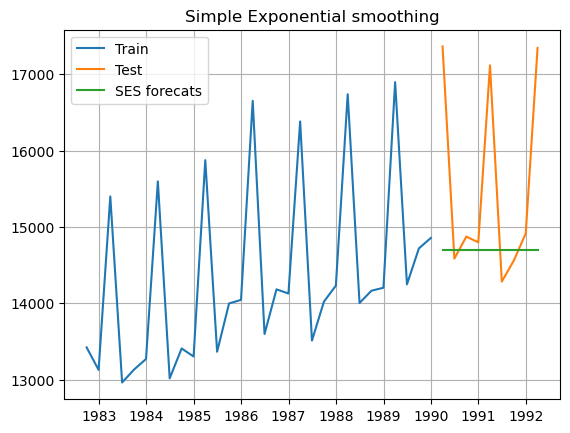

In [18]:
forcast_SES = model_SES_fit.forecast(steps=len(test))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forcast_SES, label='SES forecats')
plt.legend(loc='best')
plt.title("Simple Exponential smoothing")
plt.grid()

In [19]:
#Double Exponential Smoothing / Holt's linear Method
model_DES = Holt(train,exponential=False, initialization_method='estimated')
model_DES_fit = model_DES.fit()
model_DES_fit.summary()

Dep. Variable:,Turnover,No. Observations:,30
Model:,Holt,SSE,38756875.268
Optimized:,True,AIC,430.149
Trend:,Additive,BIC,435.753
Seasonal:,None,AICC,433.801
Seasonal Periods:,None,Date:,"Fri, 31 May 2024"
Box-Cox:,False,Time:,18:03:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0991864,alpha,True
smoothing_trend,0.0990872,beta,True


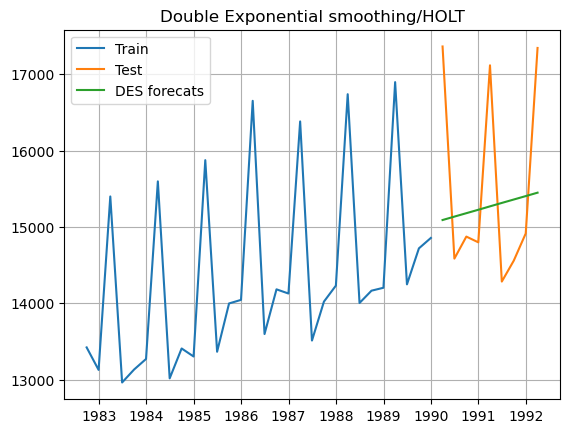

In [20]:
forcast_DES = model_DES_fit.forecast(steps=len(test))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forcast_DES, label='DES forecats')
plt.legend(loc='best')
plt.title("Double Exponential smoothing/HOLT")
plt.grid()

In [21]:
# Triple Exponential Smoothing / Holt-Winters Method

model_TES_add = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
model_TES_add = model_TES_add.fit(optimized=True)
model_TES_add.summary()

Dep. Variable:,Turnover,No. Observations:,30
Model:,ExponentialSmoothing,SSE,915524.470
Optimized:,True,AIC,325.782
Trend:,Additive,BIC,336.991
Seasonal:,Additive,AICC,337.361
Seasonal Periods:,4,Date:,"Fri, 31 May 2024"
Box-Cox:,False,Time:,18:04:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6751195,alpha,True
smoothing_trend,0.0079915,beta,True


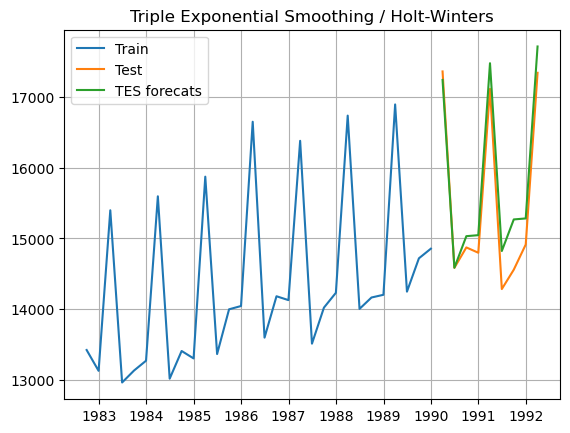

In [22]:
forecast_TES_add =  model_TES_add.forecast(steps=len(test))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_TES_add, label='TES forecats')
plt.legend(loc='best')
plt.title("Triple Exponential Smoothing / Holt-Winters")
plt.grid()

# Find MAPE for your Model

In [23]:
mean_squared_error(test.values,forecast_TES_add.values,squared=False)

380.31963826614634

In [24]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [25]:
MAPE(test['Turnover'],forecast_TES_add)

2.092650163390409